In [5]:
from netCDF4 import Dataset
import numpy as np
import os
from glob import glob
import datetime as dt
from netCDF4 import date2num,num2date
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr 

In [34]:
time_ref=dt.datetime(2012,3,18)
event_key=time_ref.strftime("%Y%m%d")
model_type = ['/normal/','/ashley/']
type_str = ['FAC-driven', 'Ashley']
by_value = ['by_neg_10/', 'by_pos_10/']
by_title = ['By = -10', 'By = +10']
precip_title = ['No Precipitation', 'Soft Precipitation']
output_type = '3dall' # '3dall' or '2dall'
ds_fin = []
save_pt = []

model_choice = 1
height = 250    
precip = True

if model_choice == 0:
    type_m = type_str[0]
    model = model_type[0]
elif model_choice == 1:
    type_m = type_str[1]
    model = model_type[1]

print ("Working on:",event_key)

if height == 400:
    event_key = str(event_key)+'_400'

for b in by_value:
    
    if output_type == '2dall':
        home_pt='/glade/work/prasoonv/gitm/code/2dall/'   
        data_pt=home_pt+event_key+model+b+'output/2dall_final/'
        if time_ref == dt.datetime(2012,3,18):
            if precip:
                data_pt += 'e_precip/'
                p_title = precip_title[1]
            else:
                data_pt += 'no_precip/' 
                p_title = precip_title[0]
    
    if output_type == '3dall':
        home_pt='/glade/work/prasoonv/gitm/3DYNAMO/3dall/'   
        data_pt=home_pt+event_key+model+'outputs/' + b + '3dall_final/'
        p_title = precip_title[1]

    print(data_pt)
    

    save_pt.append(data_pt)
    if not os.path.exists(save_pt[-1]):                                            
        os.makedirs(save_pt[-1])     

    if output_type == '2dall':
        fname=data_pt+'combined_parms_2dall.npz'
        dimensions=["ut","glon","glat"]

    if output_type == '3dall':
        fname=data_pt+'combined_parms_3dall.npz'
        dimensions=["ut","glon","glat","alt"]


    data=np.load(fname)
    print('List of all variables in data:', list(data.keys()))
    print()
    
    '''
    for key in data.files:
        print(f"Key: {key}")
        print(f"Shape: {data[key].shape}")
        print(f"Data Type: {data[key].dtype}")
        print(f"Sample Data: {data[key][:5]}")  # Print the first 5 elements
        print("="*50)
    '''

    gitm_time_ref=time_ref + dt.timedelta(days=3)
    ut=data['ut']
    ut=[(dt.timedelta(hours=(i-ut[0])) + gitm_time_ref) for i in ut]

    if output_type == '2dall':
        ds = xr.Dataset(
            coords={'ut':ut,
                    'glon':data['glon'],
                    'glat':data['glat']})
        for key in data.files[3:]:
                ds[key]=(('ut','glon','glat'),data[key])    
                
        ds_fin.append(ds)
            
            
    if output_type == '3dall':
        ds = xr.Dataset(
            coords={'ut':ut,
                    'glon':data['glon'],
                    'glat':data['glat'],
                    'alt': data['alt']})

        for key in data.files[4:]:
            ds[key]=(('ut','glon','glat','alt'),data[key])


        # Using only data for altitude = 400 km 
        #ds1 = ds.sel(alt=400, method='nearest')
        ds1 = ds.sel(alt=(ds.alt<=525) & (ds.alt>=275), drop='true')
        ds1 = ds1.mean(dim='alt')
        
        #print(ds1.Rho.values)
        
        print(ds1)
        print('ds \n', ds)
        save_name = data_pt + 'combined_parms_3dall_398km.npz'

        np.savez_compressed(
            save_name,
            ut=ds1.ut.values,
            glon=ds1.glon.values,
            glat=ds1.glat.values,
            Rho=ds1.Rho.values,
            JouleHeating=ds1.JouleHeating.values,
            Temperature=ds1.Temperature.values,
            Un=ds1.Un.values,
            Vn=ds1.Vn.values,
            Wn=ds1.Wn.values,
            qlrate_rho=ds1.qlrate_rho.values,
            u_grad_rho=ds1.u_grad_rho.values,
            v_grad_rho=ds1.v_grad_rho.values,
            w_grad_rho=ds1.w_grad_rho.values,
            rho_div_u=ds1.rho_div_u.values,
            rho_div_v=ds1.rho_div_v.values,
            rho_div_w=ds1.rho_div_w.values,
            div_rhoU_hor=ds1.div_rhoU_hor.values,
            div_rhoU_ver=ds1.div_rhoU_ver.values
        )
        
        ds_fin.append(ds1)
    
    print(ds)
    print()


Working on: 20120318
/glade/work/prasoonv/gitm/3DYNAMO/3dall/20120318/ashley/outputs/by_neg_10/3dall_final/
List of all variables in data: ['ut', 'glon', 'glat', 'alt', 'Rho', 'JouleHeating', 'Temperature', 'Un', 'Vn', 'Wn', 'qlrate_rho', 'u_grad_rho', 'v_grad_rho', 'w_grad_rho', 'rho_div_u', 'rho_div_v', 'rho_div_w', 'div_rhoU_hor', 'div_rhoU_ver']

<xarray.Dataset> Size: 15MB
Dimensions:       (ut: 24, glon: 72, glat: 72)
Coordinates:
  * ut            (ut) datetime64[ns] 192B 2012-03-21 ... 2012-03-21T22:59:59
  * glon          (glon) float64 576B 2.5 7.5 12.5 17.5 ... 347.5 352.5 357.5
  * glat          (glat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
Data variables: (12/15)
    Rho           (ut, glon, glat) float64 995kB 5.274e-12 ... 4.543e-12
    JouleHeating  (ut, glon, glat) float64 995kB 4.296e-11 ... 2.106e-11
    Temperature   (ut, glon, glat) float64 995kB 1.015e+03 ... 1.24e+03
    Un            (ut, glon, glat) float64 995kB -208.2 -209.9 ... -69.87 -133.6

In [29]:
#from apexpy import Apex

#print(ds_fin[0])

#print(ds_fin[1])

ds_mlt = []

for ds in ds_fin:
    glon2d, ut2d = np.meshgrid(ds['glon'], ds['ut'])
    
    # Converting GLON and UT to MLT. Note that only hours is necessary at end
    # Thus, MLON is still kept in (0,360) range. 24 hours change at end won't reflect at end
    offset_min = (glon2d/15)*60
    offset_td = offset_min.astype('timedelta64[m]')
    mlt = ut2d + offset_td
    ds['mlt'] = (('ut', 'glon'), mlt)
    #print(ds)
    
    

    # Round to nearest 10 minutes
    mlt_exact = xr.where(
        ds['mlt'] - ds['mlt'].dt.floor('10min') < np.timedelta64(5, 'm'),
        ds['mlt'].dt.floor('10min'),
        ds['mlt'].dt.floor('10min') + np.timedelta64(10, 'm')
    )

    ds['mlt_new'] = (('ut', 'glon'), mlt_exact.values)


    # Making new dataset that has mlt and glat as new coordinates
    # Step 1: Flatten mlt_new to 1D and get sorted unique values
    mlt_flat = ds['mlt_new'].values.flatten()
    mlt_unique_sorted = np.unique(mlt_flat)

    # Step 2: Get glat values
    glat_vals = ds['glat'].values

    # Step 3: Create new dataset dictionary
    new_data_vars = {}

    for var in ds.data_vars:
        if var in ['mlt', 'mlt_new']:
            continue  # Skip coordinate variables

        # Reshape the variable from (ut, glon, glat) to (ut*glon, glat)
        reshaped = ds[var].values.reshape(-1, len(glat_vals))

        # mlt_new is shape (ut, glon), reshape to match
        mlt_flat = ds['mlt_new'].values.flatten()

        # Create a DataArray for alignment
        da = xr.DataArray(
            data=reshaped,
            coords={'mlt_new': ('mlt_new', mlt_flat), 'glat': glat_vals},
            dims=('mlt_new', 'glat')
        )

        # Reindex to unique sorted mlt values (you could also groupby, bin, or interpolate here)
        # We'll take the first value for each unique time (you can average if needed)
        da_grouped = da.groupby('mlt_new').mean('mlt_new', skipna=True)

        # Reindex to ensure consistent output coordinates
        da_grouped = da_grouped.reindex(mlt_new=mlt_unique_sorted)

        new_data_vars[var] = da_grouped

    # Step 4: Create new dataset
    new_ds = xr.Dataset(
        data_vars=new_data_vars,
        coords={
            'mlt_new': ('mlt_new', mlt_unique_sorted),
            'glat': ('glat', glat_vals)
        }
    )

    print(new_ds)
    
    ds_mlt.append(new_ds)
    
print(ds_mlt)

<xarray.Dataset> Size: 1MB
Dimensions:       (glat: 72, mlt_new: 141)
Coordinates:
  * glat          (glat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * mlt_new       (mlt_new) datetime64[ns] 1kB 2012-03-21T00:10:00 ... 2012-0...
Data variables: (12/15)
    Rho           (mlt_new, glat) float64 81kB 2.361e-12 2.277e-12 ... 2.08e-12
    JouleHeating  (mlt_new, glat) float64 81kB 1.281e-11 7.808e-12 ... 8.263e-12
    Temperature   (mlt_new, glat) float64 81kB 1.019e+03 1.018e+03 ... 1.245e+03
    Un            (mlt_new, glat) float64 81kB -210.3 -211.7 ... -74.38 -138.6
    Vn            (mlt_new, glat) float64 81kB 189.2 193.1 ... -600.4 -577.0
    Wn            (mlt_new, glat) float64 81kB 9.203 6.859 ... -2.434 -4.76
    ...            ...
    w_grad_rho    (mlt_new, glat) float64 81kB 3.84e-16 2.74e-16 ... -1.679e-16
    rho_div_u     (mlt_new, glat) float64 81kB 2.836e-15 9.404e-16 ... 8.345e-15
    rho_div_v     (mlt_new, glat) float64 81kB -3.071e-15 ... -8.303e-15


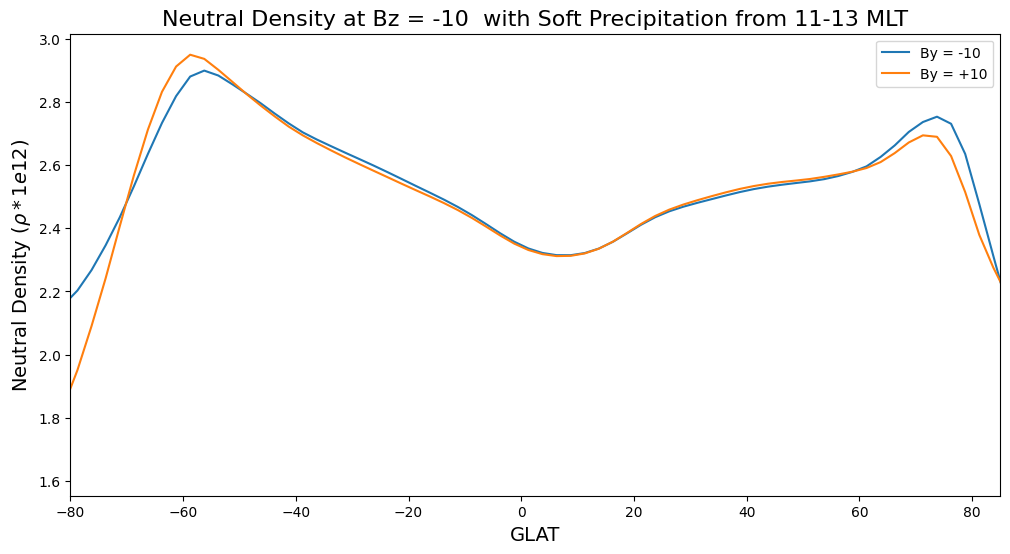

In [26]:
ds1 = []

for ds, t in zip(ds_mlt, by_value):
    time_start = pd.to_datetime('2012-03-21 11:00:00')
    time_end = pd.to_datetime('2012-03-21 13:00:00')
    ds = ds.sel(mlt_new=slice(time_start, time_end))
    
    ds_t = ds.mean(dim='mlt_new')
    ds_t['Rho'] = ds_t.Rho * 1e12    
    ds1.append(ds_t)


#print(ds1)

fig = plt.figure(figsize=(12,6))
specs = fig.add_gridspec(1,1, hspace=0.3)

ax1 = fig.add_subplot(specs[0])
ax1.plot(ds1[0].glat, ds1[0].Rho, label=by_title[0])
ax1.plot(ds1[1].glat, ds1[1].Rho, label=by_title[1])
ax1.set_xlabel('GLAT',fontsize=14)
ax1.set_ylabel(r'Neutral Density ($\rho*1e12$)',fontsize=14)
ax1.legend()
ax1.set_title(f'Neutral Density at Bz = -10  with {p_title} from 11-13 MLT',fontsize=16)
#ax1.set_ylim(2,3)
ax1.set_xlim(-80,85)

'''
ax2 = fig.add_subplot(specs[1])
ax2.plot(ds1[0].glat, ds1[0].ExB, label='By Negative')
ax2.plot(ds1[1].glat, ds1[1].ExB, label='By Positive')
ax2.set_title('Radial ExB Drift for Bz = -10 from 11-13 MLT at all Latitudes',fontsize=16)
ax2.set_xlabel('GLAT',fontsize=14)
ax2.set_ylabel('Upward (Radial) ExB Drift',fontsize=14)
ax2.legend()
ax2.set_xlim(-80,85)
ax2.set_ylim(0,65)
''';


Data keys in zpf file: ['ut', 'glon', 'glat', 'Rho', 'JouleHeating', 'Temperature', 'Un', 'Vn', 'Wn', 'qlrate_rho', 'u_grad_rho', 'v_grad_rho', 'w_grad_rho', 'rho_div_u', 'rho_div_v', 'rho_div_w', 'div_rhoU_hor', 'div_rhoU_ver']
2012-03-21 00:00:00
2012-03-21 01:00:01
2012-03-21 02:00:00
2012-03-21 03:00:00
2012-03-21 04:00:00
2012-03-21 04:59:59
2012-03-21 06:00:00
2012-03-21 07:00:01
2012-03-21 07:59:59
2012-03-21 09:00:00
2012-03-21 09:59:59
2012-03-21 11:00:00
2012-03-21 12:00:00
2012-03-21 13:00:00
2012-03-21 14:00:00
2012-03-21 14:59:59
2012-03-21 16:00:00
2012-03-21 17:00:00
2012-03-21 18:00:00
2012-03-21 18:59:59
2012-03-21 19:59:59
2012-03-21 20:59:59
2012-03-21 21:59:59
2012-03-21 22:59:59
/glade/work/prasoonv/gitm/3DYNAMO/3dall/20120318/ashley/outputs/by_neg_10/3dall_final/sum_plot/by_neg_10.pdf


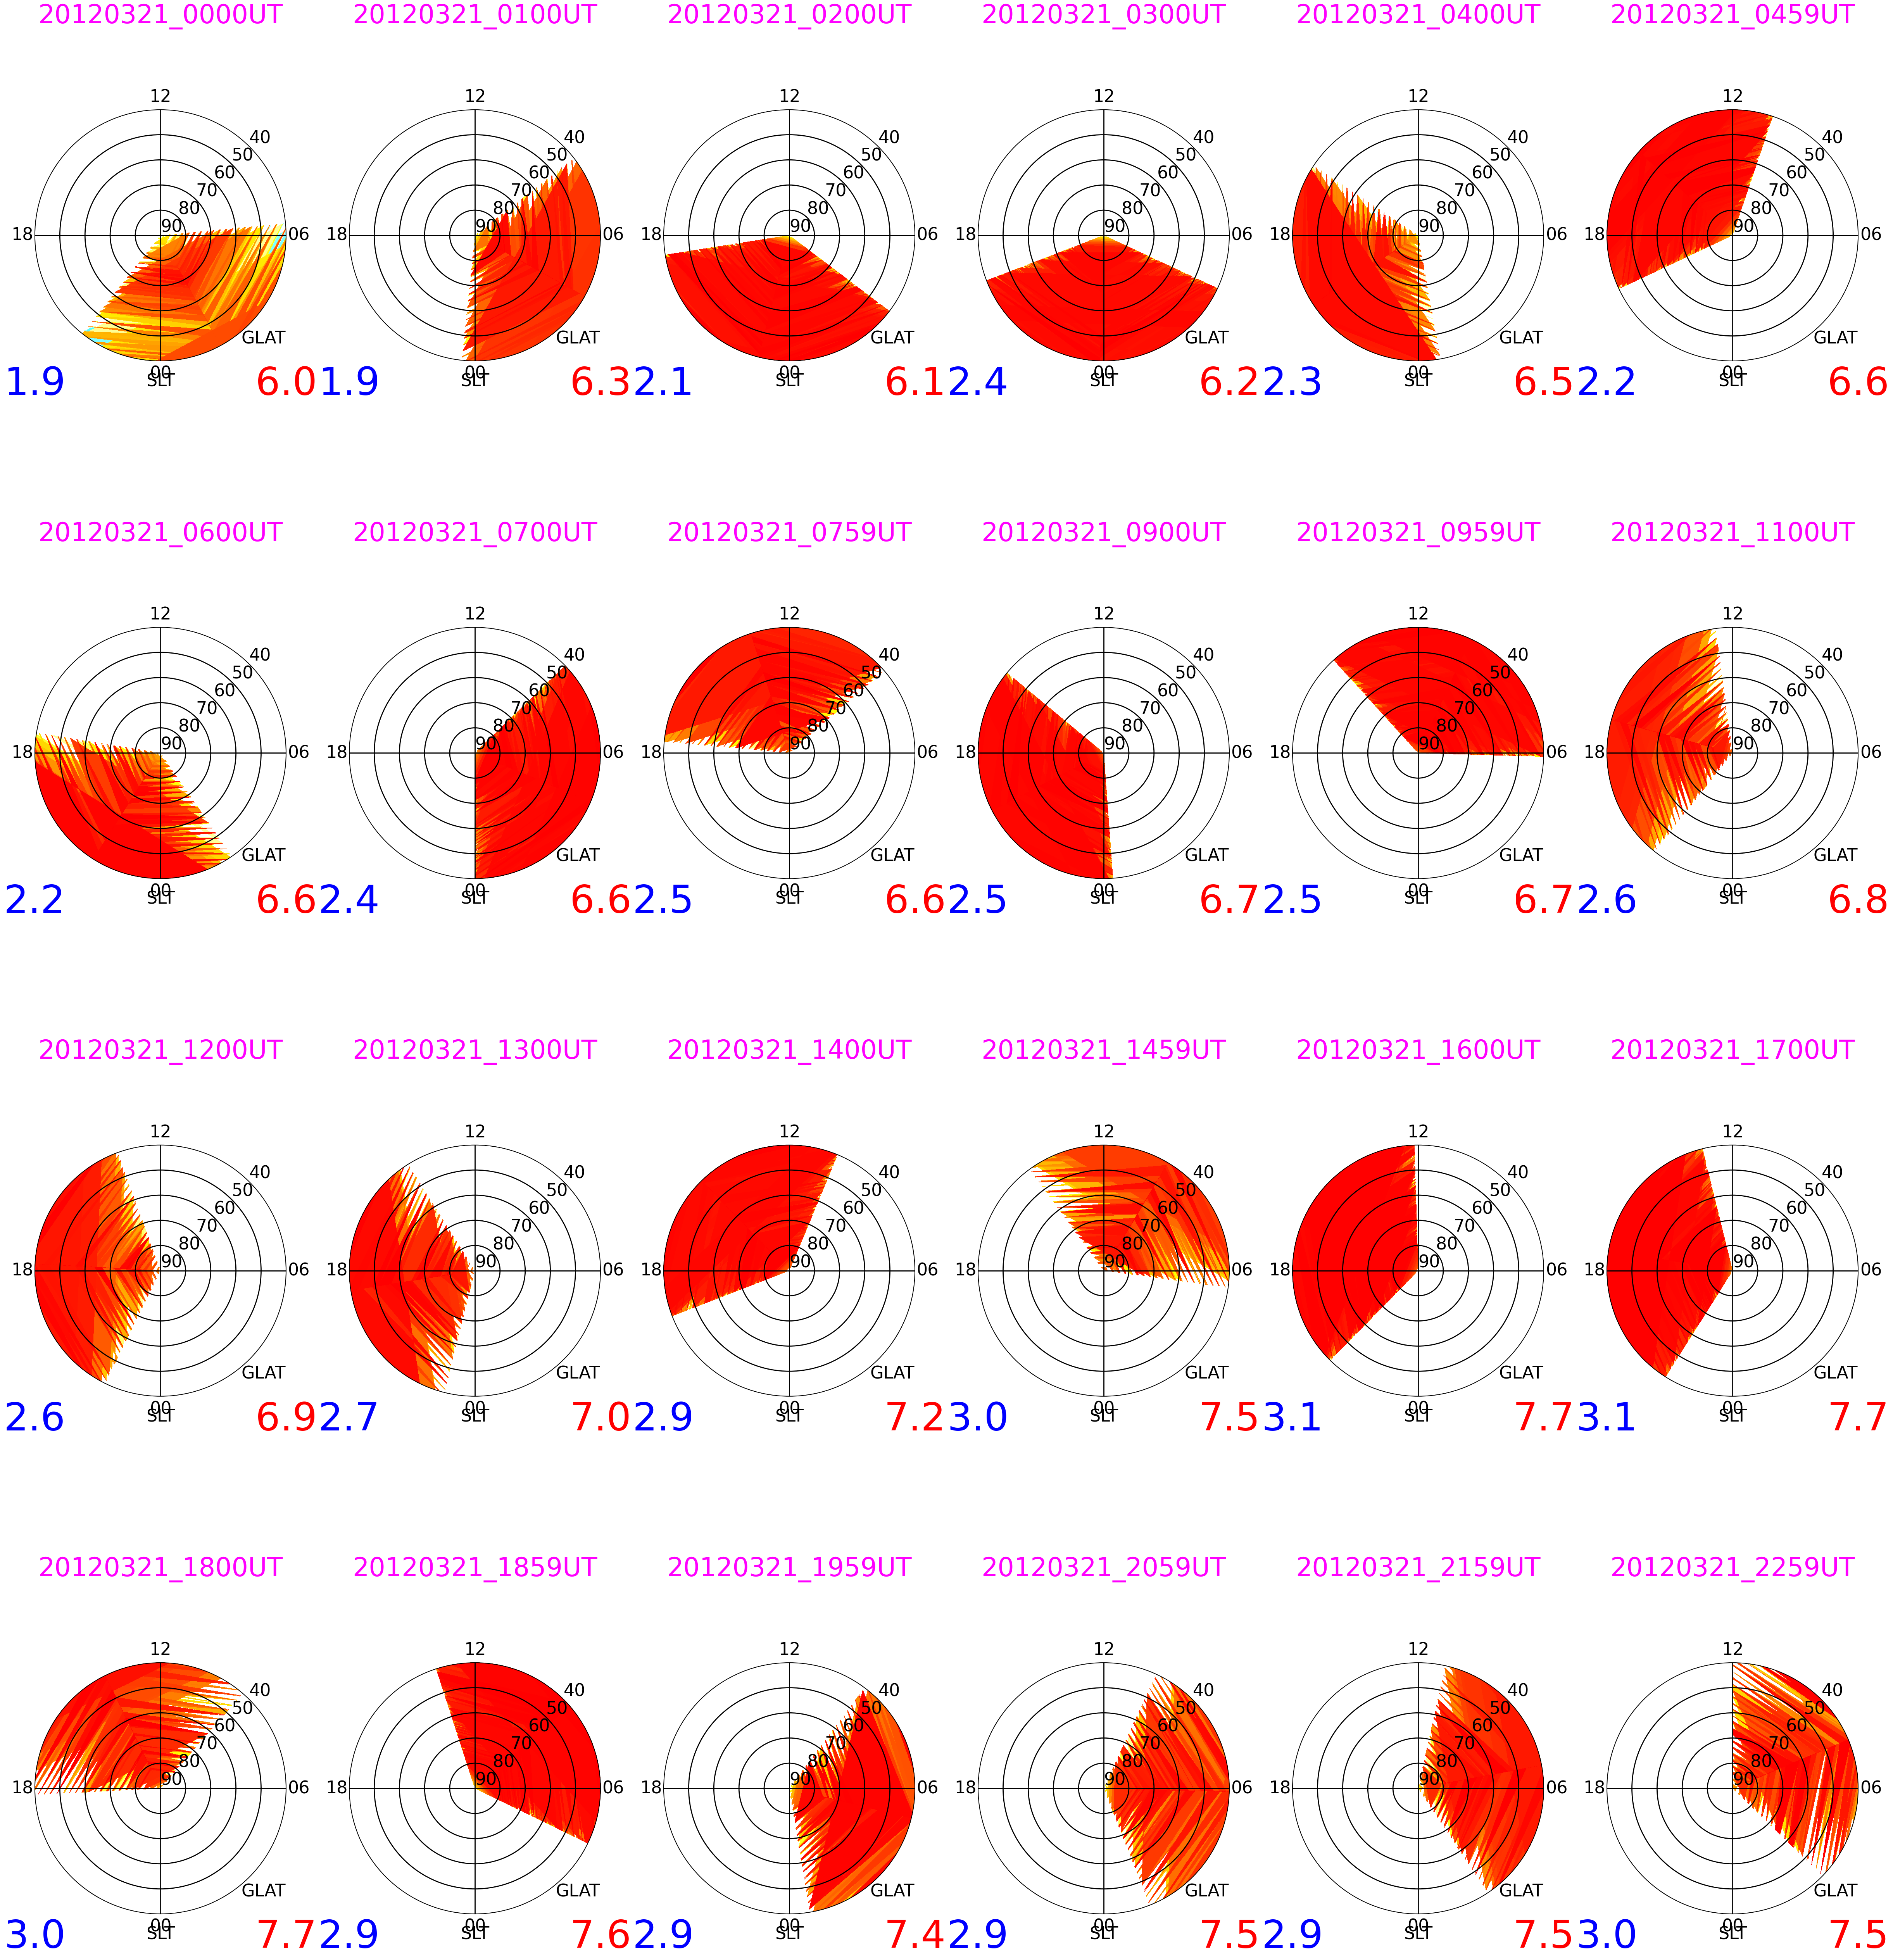

In [ ]:
import sys                                                                      
sys.path.append('/glade/work/prasoonv/gitm/library_ext/libpy') # Change it  

import numpy as np                                                              
import os                                                                       
from glob import glob                                                           
import datetime as dt  
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

from set_polar_plots import set_polar_plot, add_axvcolorbar1                                    
from cmap_mylib import make_mid                                                 
                                                                                
from gitm_parms import gitm_contourf, gitm_contour  
from set_figs import add_str 

time_ref=dt.datetime(2012,3,21) 


path = '/glade/work/prasoonv/gitm/'
output_type = '3dall' # '2dall' or '3dall'
by_nature = ['by_neg_10/', 'by_pos_10/']
precip = ['no_precip/', 'e_precip/']
by = by_nature[0]
prec = precip[0]

data_fn = ''
if output_type == '2dall':
    data_pt = path + f'code/2dall/20120318/ashley/{by}output/2dall_final/{prec}'
    data_fn = data_pt + 'combined_parms_2dall.npz'

if output_type == '3dall':
    data_pt = path + f'3DYNAMO/3dall/20120318/ashley/outputs/{by}3dall_final/'
    data_fn = data_pt + 'combined_parms_3dall_398km.npz'
#data_fn = 'path_to_file' # Change it


data=np.load(data_fn)                                                           
print('Data keys in zpf file:', list(data.keys()))
ut=data['ut']                                                                   
lon=data['glon']                                                                
lat=data['glat']                                                                
rho=data['Rho']*1e12
if output_type == '2dall':                                                                                   
    pot=data['pot']/1000  
    int_jh=data['int_jh']*1000

save_pt=data_pt + 'sum_plot/'
if not os.path.exists(save_pt):
    os.makedirs(save_pt)


nut=len(ut)
cmap=make_mid(256)

"""
Change the figure size and parameters in the subplots_adjust
"""
fig,axes=plt.subplots(4,6,figsize=(56,60),subplot_kw={'projection': 'polar'})
plt.subplots_adjust(left=0.08,right=0.92,bottom=0.05,top=0.92,wspace=0.25,hspace=0.1)

for iut in range(nut):
    
    ut_in=ut[iut]
    
    if output_type == '2dall':        
        if ut_in<0:
            continue
        time1=time_ref+dt.timedelta(seconds=round(ut_in*3600))
    
    if output_type == '3dall':
        ut_in_dt = ut_in.astype('datetime64[s]').astype(dt.datetime)
        delta_seconds = (ut_in_dt - time_ref).total_seconds()
        time1 = time_ref + dt.timedelta(seconds=round(delta_seconds))

    
    print (time1)
    
    time_str=time1.strftime("%Y%m%d_%H%MUT")
    
    irow = int(iut/6)
    icol = iut - irow * 6
    
    
    
    #%%
    ax = axes[irow,icol]
    
    vmin=0                                                                    
    vmax=6     # Change it                                        
    cs_step=0.2                                                             
    cb_step=2
    
    parm=rho[iut]
    fp=lat>0                                                                    
    pot_max=round(parm[:,fp].max(),1)                                             
    pot_min=round(parm[:,fp].min(),1)                                             
    add_str(str(pot_max),ax,fig,72,'r',4,0,-0.01,'center','center')             
    add_str(str(pot_min),ax,fig,72,'b',1,0,-0.01,'center','center') 
    
    
    ang=lon/180*np.pi                                                           
    r=90-lat
    
    
    ang,r=np.meshgrid(ang,r)                                                    
    ang=ang.T                                                                   
    r=r.T                                                                       
                                                                                
    ang_offset=int(ut_in)/12*np.pi-np.pi/2
    im=gitm_contourf(ax,parm,vmin,vmax,cs_step,cmap,ang,r,ang_offset)

    # Change the parameters if needed
    set_polar_plot(fig,ax,                                                      
                   50,32,'k','k',                                               
                   time_str,0.04,48,'magenta',                                            
                   32,5,32,8,0) 
    
    
    
save_fn = save_pt+by[:-1]+'.pdf'
print(save_fn)
plt.savefig(save_fn, bbox_inches='tight', pad_inches=0) # Change it
#plt.show()
#plt.close()
